# Image Colorization using regression CNN

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
import os.path as osp
import time
from torch.utils import data as D
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
#from show_data import imshow #, imshow2

# Todos
# Make sure IDs of pictures are available
# Reduce net size
# Change to 54x54 ab picture and then upscale
# Enable validation set (?)
# Enable storing of parameters
# Enable running on arbitrary picture
# Implement new net


## Data utility functions

In [9]:
# Dataset class for preprocessed tensor data
class Image256(D.Dataset):
    def __init__(self, path, N = None):    
        self.root = path
        feature_images = []
        target_images = []
        self.org_images = []
        self.image_names = []
        
        filenames = glob.glob(osp.join(path, '*.pt'))
        
        Nfiles = len(filenames)
        counter = 0
        for fn in filenames:
            counter += 1
            img = torch.load(fn)
            
            # Extract the L-image (bw image)
            bwimage = img[0].float()
            bwimage = bwimage[None,:,:]
            feature_images.append(bwimage)
            
            # Extract colour layers and resize
            colimage = img[1:3].float()
            target_images.append(colimage)
            
            # Store original image and name
            self.org_images.append(img)
            file_path, file_name = osp.split(fn)
            self.image_names.append(fn.split('.')[0])
            
            if counter % 1000 == 0:
                print(counter,'images parsed')
            if N and counter == N:
                break
        
        self.training_data = torch.stack(feature_images)
        self.target_data = torch.stack(target_images)
        self.len = len(feature_images)
        print('Read',self.len,'images')
               
    def __getitem__(self, index):
        return self.training_data[index]
    
    def __len__(self):
        return self.len
    
    def training_data():
        return self.training_data
    

def imshow2(img_tensor, img_tensor2):
    img_tensor = np.transpose(img_tensor.numpy(), (1,2,0))
    img_tensor2 = np.transpose(img_tensor2.numpy(), (1,2,0))
    
    img = lab2rgb(img_tensor)
    img2 = lab2rgb(img_tensor2)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img)
    axarr[1].imshow(img2)
    plt.show()



## Network configuration

In [10]:
# [batch_size, channel, height, width]

class NaiveNet(torch.nn.Module):
    def __init__(self):
        super(NaiveNet, self).__init__()
        self.layer1 = torch.nn.Sequential(
            # (1 x 224 x 224)
            torch.nn.Conv2d(1, 32, kernel_size=5, padding=2),
            # -> (32 x 224 x 224)
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=2)
            # -> (32 x 112 x 112)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(8),
            torch.nn.MaxPool2d(kernel_size=2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(2),
            torch.nn.ConvTranspose2d(2,2,kernel_size=4, padding=0, stride=4))
        
        # The resulting dimensions from the three layers (+input) are as follows:
        #torch.Size([1, 1, 224, 224])
        #torch.Size([1, 32, 112, 112])
        #torch.Size([1, 8, 56, 56])
        #torch.Size([1, 2, 56, 56])
        # finally -> 1, 2, 256, 256

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        print(x.shape)
        return x

## Configuration parameters

In [11]:
# GPU Governs if GPU on Floydhub is used
USE_GPU = False
# SET TRAINING PARAMETERS
N_BATCH  = 100
N_EPOCHS    = 10
N_TRAINING = 300
PERFORM_TRAINING = True

## Read image data

In [12]:
if USE_GPU:
    # GPU assumes the Sacharias tree training 1 dataset is loaded on Floyd
    path = '/floyd/input/tree_training_1_tensor/'
else:
    # The local *.pt repository is in ./data
    path = 'data/'

imagedata = Image256(path, N_TRAINING)

#net = NaiveNet().float()



Read 300 images


## Test run one forward pass

In [15]:

print(len(imagedata))
net = NaiveNet().float()
res = net.forward(imagedata[0][None,:,:,:])

300
torch.Size([1, 2, 224, 224])


## Train net

torch.Size([100, 2, 224, 224])


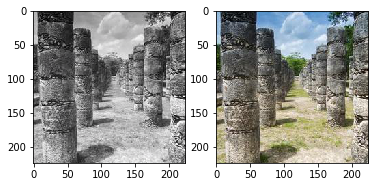

Epoch 0 Image 0 tensor(298.8836, grad_fn=<AddBackward0>) tensor(298.8836, grad_fn=<MseLossBackward>)
torch.Size([100, 2, 224, 224])


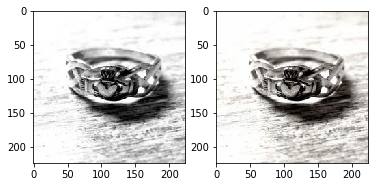

Epoch 0 Image 100 tensor(654.7417, grad_fn=<AddBackward0>) tensor(355.8581, grad_fn=<MseLossBackward>)
torch.Size([100, 2, 224, 224])


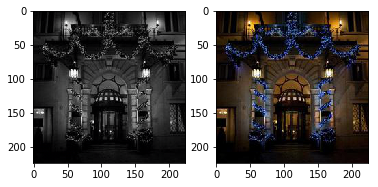

Epoch 0 Image 200 tensor(966.5534, grad_fn=<AddBackward0>) tensor(311.8117, grad_fn=<MseLossBackward>)
torch.Size([100, 2, 224, 224])


KeyboardInterrupt: 

In [16]:

if PERFORM_TRAINING:

    if USE_GPU:
        model = NaiveNet().cuda()
    else:
        model = NaiveNet()
    
    
    loss_function  = torch.nn.MSELoss()
    optimizer   = torch.optim.RMSprop(model.parameters(), lr=1e-2)
    #optimizer   = torch.optim.SGD(model.parameters(), lr=1e-2) 
    training_data = imagedata.training_data
    target_data = imagedata.target_data
     
    for epoch in range(N_EPOCHS):
        running_train_loss = .0
        running_valid_loss = .0
        for i in range(0, N_TRAINING, N_BATCH):
            
            # Prepare one batch and tensorise
            batch_features = training_data[i:i + N_BATCH].float()
            batch_targets = target_data[i:i + N_BATCH].float()
            if USE_GPU:
                batch_features = batch_features.cuda()
                batch_targets = batch_targets.cuda()
            training_tensor = torch.autograd.Variable(batch_features, requires_grad=False)
            target_tensor = torch.autograd.Variable(batch_targets, requires_grad=False)

            # Perform one forward step, compute loss function and update parameters with a backprop 
            optimizer.zero_grad()

            train_output    = model(training_tensor)
            train_loss      = loss_function(train_output, target_tensor)
            
            # Backprop
            train_loss.backward()
            optimizer.step()

            running_train_loss += train_loss
            
            if i % 100 == 0:
                img = torch.stack([training_tensor[0][0],train_output[0][0], train_output[0][1]])
                imshow2(img.detach().cpu(), imagedata.org_images[i])
                print('Epoch',epoch,'Image',i,running_train_loss, train_loss)
        



In [ ]:
a = torch.tensor([[0,2,3,4],[0,1,2,3],[0,1,9,3]])

In [129]:
a.shape

torch.Size([3, 4])

In [130]:
a[1:3]

tensor([[0, 1, 2, 3],
        [0, 1, 9, 3]])